# Fraud Detection Analysis

# Understanding the problem

Fraud detection during transactions is a critical task in various industries, especially in financial services. The goal is to identify and prevent fraudulent activities to protect customers, businesses, and financial institutions from potential losses. In our context we have data records of over 6 million records that includes details of customerID, mode of payment and balances on both receiver's and sender's accounts before and after transaction. The key goal is to identify whether a particular transaction given all its properties is liable to be a fraudelent transaction or not.

# Gather Data

In [1]:
 #import all the necessary modules/libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
#!pip install --upgrade seaborn

In [2]:
#Read the data from the file
df = pd.read_csv("Fraud.csv")

# Exploratory Data Analysis

# Data Preprocessing

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['step', 'isFraud', 'isFlaggedFraud'], dtype='object'),
 dtype('float64'): Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
        'newbalanceDest'],
       dtype='object'),
 dtype('O'): Index(['type', 'nameOrig', 'nameDest'], dtype='object')}

In [8]:
df.describe(include=object)

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C363736674,C1286084959
freq,2237500,3,113


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


0.9987116942391656 1.0 0.0019481310118105442 0.0038886863531413293


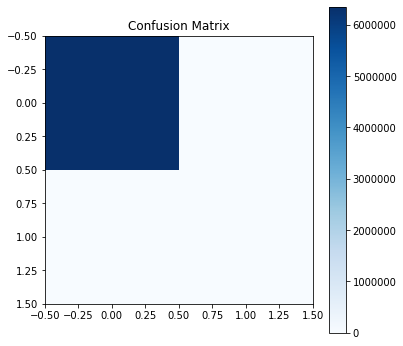

In [9]:
#To check the accuracy of isFlaggedFraud against isFraud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


# Create the confusion matrix
cm_flag = confusion_matrix(df['isFraud'], df['isFlaggedFraud'])

# Calculate true positives, true negatives, false positives, false negatives
tn, fp, fn, tp = cm_flag.ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm_flag, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
print(accuracy, precision, recall, f1_score)



In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
(df['isFraud'].value_counts() / len(df)) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

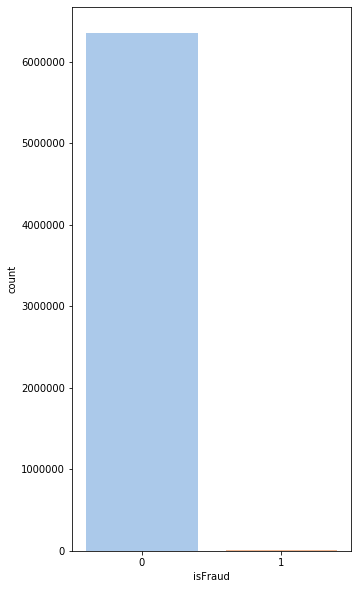

In [12]:
plt.figure(figsize=(5, 10))
sns.countplot(x="isFraud", data=df, palette="pastel")

Here , we see the transaction termed as fraudelent is only 0.129%. This indicates a high level of imbalance in the dataset. To, counter this issue we can use several techniques to handle imbalanced datasets like undersampling, oversampling, SMOTE technique, stratified sampling etc.

Generally when it comes to artificially balancing dataset, the stakeholder's approval is recommended beforehand.
I will train the dataset without artificially balancing by using models recommended for imbalanced datasets like Random Forest, and Logistic Regression.


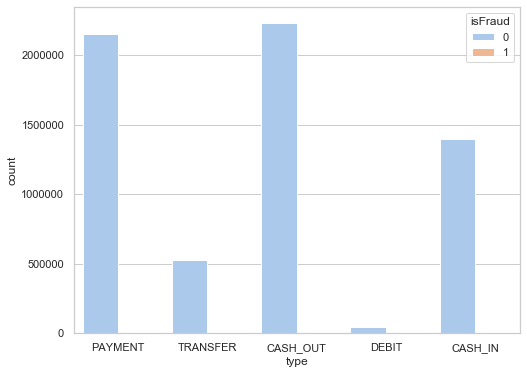

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.countplot(x="type", hue="isFraud", data=df, palette="pastel")

In [14]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

We are notified that the recipients whose name starts with M (Merchants) do not have information regarding their old and new balance.

In [15]:
df['nameDest'].str.startswith('M').sum()

2151495

In [16]:
#to check how many non-fraudelent cases in Merchant transaction
len(df[(df['nameDest'].str.startswith('M')) & (df['isFraud'] == 0)])

2151495

In [17]:
len(df[(df['nameDest'].str.startswith('M')) & (df['isFraud'] == 1)])

0

Before dropping, we should perform all these preprocessing on a separate dataset to retain the original one.

In [3]:
df_fin=df.copy()

In [4]:
#drop the rows where the nameDest starts with M
df_fin = df_fin[~df_fin['nameDest'].str.startswith('M')]
df_fin.shape

(4211125, 11)

In [21]:
df_fin['type'].value_counts()

CASH_OUT    2237500
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

The above data shows that all the transactions done to the Merchants are done via Payment type transaction and all Payment type transctions are done to the Mercants as destination.

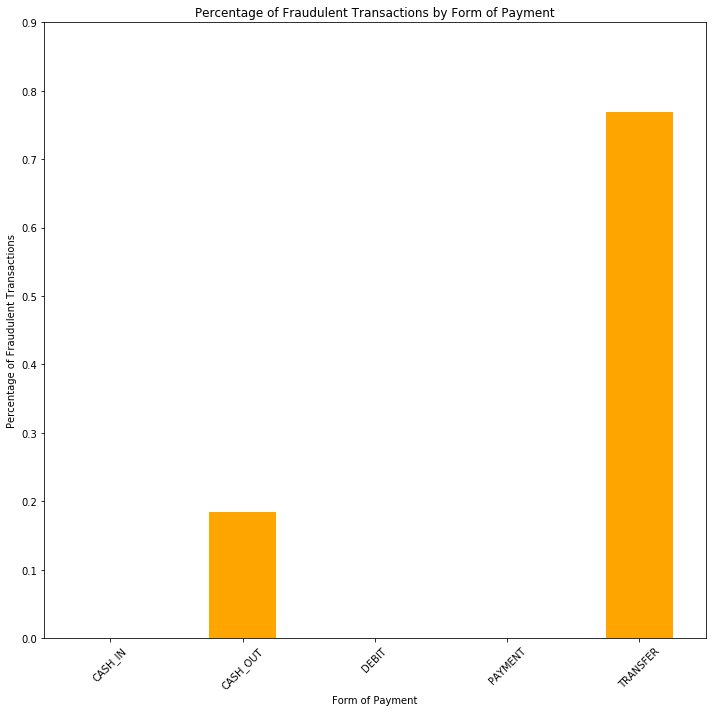

In [5]:
#let's check the percentage of fraudelent cases grouped by type of payment

fraud_percentage = df[df['isFraud'] == 1].groupby('type').size() / df.groupby('type').size() * 100

# Plot the bar graph
plt.figure(figsize=(10, 10))
fraud_percentage.plot(kind='bar', color='orange')
plt.title('Percentage of Fraudulent Transactions by Form of Payment')
plt.xlabel('Form of Payment')
plt.ylabel('Percentage of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.ylim(0, 0.9)
plt.tight_layout()
plt.show()


In [23]:
fraud_percentage

type
CASH_IN          NaN
CASH_OUT    0.183955
DEBIT            NaN
PAYMENT          NaN
TRANSFER    0.768799
dtype: float64

The above data shows that fraudelent cases happen only in case of cash_out and transfers. So,the rest of the payment types we can drop

In [6]:
df_fin = df_fin[~df_fin['type'].isin(['CASH_IN', 'DEBIT'])]

In [7]:
df_fin.shape

(2770409, 11)

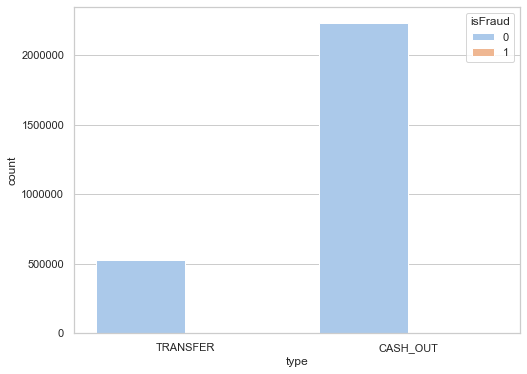

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.countplot(x="type", hue="isFraud", data=df_fin, palette="pastel")

In [27]:
df_fin['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [9]:
df_fin['isFraud'].value_counts() / len(df_fin) * 100

0    99.703546
1     0.296454
Name: isFraud, dtype: float64

We see that the dataset imbalance has slightly improved, but the difference is negligible

In [29]:
#to check for nan values
df_fin.isna().any().sum()

0

In [30]:
#to check for null values
df_fin.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In this context the columns nameOrig and nameDest are not required for the classification model, so we can drop those. Moreover encoding for unique names would take a lot of space. 

In [10]:
df_fin= df_fin.drop(columns='nameDest')
df_fin =df_fin.drop(columns='nameOrig')

In [32]:
df_fin.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,0


In [33]:
df_fin.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,0


Before heading towards checking multicollinearity, we should separate the independent and dependent variables and perform standardization. 

In [11]:
x =  df_fin.loc[:,df_fin.columns != 'isFraud']

In [12]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [13]:
y= df_fin.loc[:,'isFraud']

In [37]:
y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

In [38]:
print(y)

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64


# Without artificially balancing the dataset

# Train-Test Split

I will apply standardization separately on training and testing set to avoid data leakage.

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)
x_train.shape

(1939286, 8)

In [40]:
x_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
918174,43,CASH_OUT,106794.09,0.00,0.0,1605519.85,1712313.94,0
3322392,253,CASH_OUT,122557.44,9594.02,0.0,220641.55,343198.99,0
4878042,348,CASH_OUT,161321.72,86615.00,0.0,0.00,161321.72,0
5732754,399,CASH_OUT,25551.54,0.00,0.0,554978.97,580530.51,0
5332240,374,CASH_OUT,80743.12,0.00,0.0,5177961.26,5258704.38,0


In [41]:
x_test.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
3328189,253,CASH_OUT,87746.30,0.00,0.00,263589.17,351335.48,0
3444441,257,CASH_OUT,117524.85,908519.16,790994.31,238916.73,356441.58,0
4662934,330,CASH_OUT,211534.63,10474.00,0.00,213380.91,424915.54,0
6044275,490,CASH_OUT,452444.67,28405.67,0.00,463269.00,915713.67,0
4054736,300,CASH_OUT,173259.62,0.00,0.00,2454686.63,2807553.18,0


In [42]:
y_train.head()

918174     0
3322392    0
4878042    0
5732754    0
5332240    0
Name: isFraud, dtype: int64

In [43]:
y_test.head()

3328189    0
3444441    0
4662934    0
6044275    0
4054736    0
Name: isFraud, dtype: int64

# One Hot Encoding training and test set

In [44]:
x_train_encoded = pd.get_dummies(x_train, columns=['type'], prefix=['type'])
x_test_encoded = pd.get_dummies(x_test, columns=['type'], prefix=['type'])

In [45]:
x_train_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
918174,43,106794.09,0.00,0.0,1605519.85,1712313.94,0,1,0
3322392,253,122557.44,9594.02,0.0,220641.55,343198.99,0,1,0
4878042,348,161321.72,86615.00,0.0,0.00,161321.72,0,1,0
5732754,399,25551.54,0.00,0.0,554978.97,580530.51,0,1,0
5332240,374,80743.12,0.00,0.0,5177961.26,5258704.38,0,1,0


In [46]:
x_test_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
3328189,253,87746.30,0.00,0.00,263589.17,351335.48,0,1,0
3444441,257,117524.85,908519.16,790994.31,238916.73,356441.58,0,1,0
4662934,330,211534.63,10474.00,0.00,213380.91,424915.54,0,1,0
6044275,490,452444.67,28405.67,0.00,463269.00,915713.67,0,1,0
4054736,300,173259.62,0.00,0.00,2454686.63,2807553.18,0,1,0


# Standardization on train and test dataset

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train_encoded)

# Transform the training and test sets using the fitted scaler
X_train_scaled = scaler.transform(x_train_encoded)
X_test_scaled = scaler.transform(x_test_encoded)

# Convert the scaled arrays back to DataFrames (optional, for visualization purposes)
x_train_one = pd.DataFrame(X_train_scaled, columns=x_train_encoded.columns)
x_test_one = pd.DataFrame(X_test_scaled, columns=x_test_encoded.columns)

In [49]:
x_train_one.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,0.056604,0.001447,0.000000,0.0,0.004518,0.004810,0.0,1.0,0.0
1,0.339623,0.001660,0.000214,0.0,0.000621,0.000964,0.0,1.0,0.0
2,0.467655,0.002185,0.001929,0.0,0.000000,0.000453,0.0,1.0,0.0
3,0.536388,0.000346,0.000000,0.0,0.001562,0.001631,0.0,1.0,0.0
4,0.502695,0.001094,0.000000,0.0,0.014570,0.014771,0.0,1.0,0.0


In [50]:
x_test_one.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,0.339623,0.001189,0.000000,0.000000,0.000742,0.000987,0.0,1.0,0.0
1,0.345013,0.001592,0.020238,0.019091,0.000672,0.001001,0.0,1.0,0.0
2,0.443396,0.002865,0.000233,0.000000,0.000600,0.001194,0.0,1.0,0.0
3,0.659030,0.006129,0.000633,0.000000,0.001304,0.002572,0.0,1.0,0.0
4,0.402965,0.002347,0.000000,0.000000,0.006907,0.007886,0.0,1.0,0.0


It is generally advisable to check multicollinearity on training set of your dataset rather than the entire dataset. This is because the purpose of identifying and handling multicollinearity is to ensure the stability and reliability of the model you build using the training data.

# Checking for Multicollinearity using Correlation Matrix and VIF

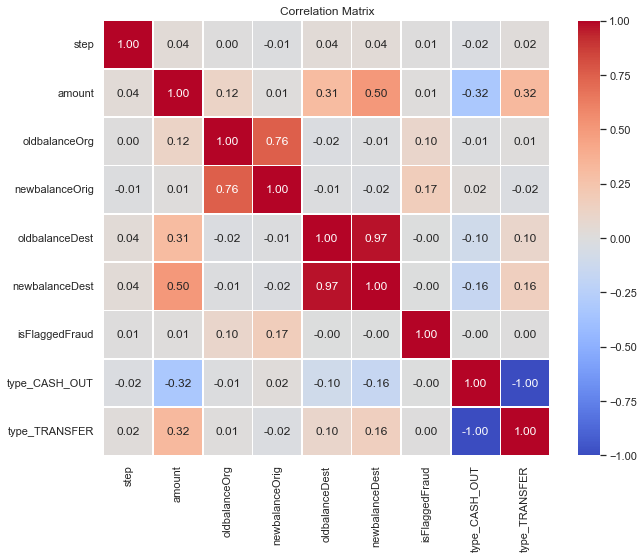

In [51]:
#Correlation
correlation_matrix = x_train_one.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

ok= add_constant(x_train_one)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = ok.columns
vif["VIF"] = [variance_inflation_factor(ok.values, i) for i in range(ok.shape[1])]

print(vif)

          Feature        VIF
0           const   0.000000
1            step   1.004073
2          amount   4.728349
3   oldbalanceOrg   2.471889
4  newbalanceOrig   2.434556
5  oldbalanceDest  55.698787
6  newbalanceDest  67.412463
7  isFlaggedFraud   1.034195
8   type_CASH_OUT        inf
9   type_TRANSFER        inf


Here, we see that newbalanceOrig and oldbalanceOrg are highly correlated, so are oldbalanceDest and newbalanceDest. To handle such level of multicollinearity we can combine the highly correlated pairs, or apply Ridge Regression and Lasso. Here type_CASH_OUT and type_TRANSFER are inf because only these two payment methods show some fraudelent transactions.

In [54]:
#combining newbalanceDest and oldbalanceDest in train and test dataset and dropping the individual columns
x_train_one['balance_comb'] =  x_train_one.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
x_test_one['balance_comb'] = x_test_one.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)

x_train_one = x_train_one.drop(['oldbalanceDest','newbalanceDest'],axis=1)
x_test_one = x_test_one.drop(['oldbalanceDest','newbalanceDest'],axis=1)

In [55]:
x_train_one.head()

,step,amount,oldbalanceOrg,newbalanceOrig,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,balance_comb
0,0.056604,0.001447,0.000000,0.0,0.0,1.0,0.0,-0.000292
1,0.339623,0.001660,0.000214,0.0,0.0,1.0,0.0,-0.000343
2,0.467655,0.002185,0.001929,0.0,0.0,1.0,0.0,-0.000453
3,0.536388,0.000346,0.000000,0.0,0.0,1.0,0.0,-0.000069
4,0.502695,0.001094,0.000000,0.0,0.0,1.0,0.0,-0.000201


In [56]:
x_test_one.head()

,step,amount,oldbalanceOrg,newbalanceOrig,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,balance_comb
0,0.339623,0.001189,0.000000,0.000000,0.0,1.0,0.0,-0.000245
1,0.345013,0.001592,0.020238,0.019091,0.0,1.0,0.0,-0.000329
2,0.443396,0.002865,0.000233,0.000000,0.0,1.0,0.0,-0.000593
3,0.659030,0.006129,0.000633,0.000000,0.0,1.0,0.0,-0.001269
4,0.402965,0.002347,0.000000,0.000000,0.0,1.0,0.0,-0.000979


Calculate VIF again

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

ok= add_constant(x_train_one)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = ok.columns
vif["VIF"] = [variance_inflation_factor(ok.values, i) for i in range(ok.shape[1])]

print(vif)

          Feature       VIF
0           const  0.000000
1            step  1.003331
2          amount  4.568078
3   oldbalanceOrg  2.456429
4  newbalanceOrig  2.428973
5  isFlaggedFraud  1.034141
6   type_CASH_OUT       inf
7   type_TRANSFER       inf
8    balance_comb  4.288863


# Applying Machine Learning Algorithms 

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 15)
classifier.fit(x_train_one, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [59]:
y_pred = classifier.predict(x_test_one)

In [60]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[828634     48]
 [   450   1991]]


In [61]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828682
           1       0.98      0.82      0.89      2441

    accuracy                           1.00    831123
   macro avg       0.99      0.91      0.94    831123
weighted avg       1.00      1.00      1.00    831123



In [62]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.999400810710328


# AUC-ROC Curve

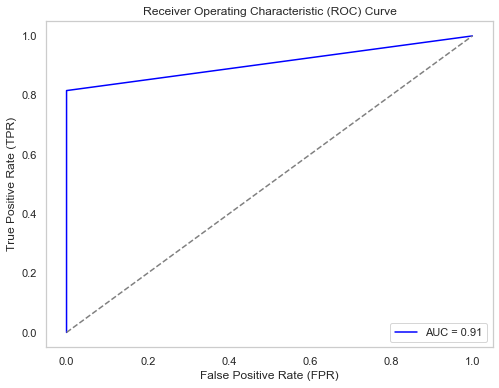

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have a trained model called 'model' and test data X_test and y_test with labels 'yes' and 'no'

# Step 1: Map 'yes' to 1 and 'no' to 0 in the y_test
# y_test_binary = np.where(y_test == 'Yes', 1, 0)
# predictions_binary = np.where(predictions == 'Yes', 1, 0) #this is the addition that I did, before this line it showed "unsupported operand type(s) for -: 'str' and 'str'" because while y_test was converted to int but the values in predictions were still string type

# Step 2: Predict probabilities of the positive class (labeled as 1)
y_prob = classifier.predict_proba(x_test_one)[:, 1]

# Step 3: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Step 4: Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred)

# Step 5: Plot the AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Logistic Regression

In [65]:
#import the model from sklearn
from sklearn.linear_model import LogisticRegression

#initialize
logmodel = LogisticRegression()

#train
logmodel.fit(x_train_one,y_train)

#predict
y_pred_lr = logmodel.predict(x_test_one)

In [67]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[828668,     14],
       [  2125,    316]], dtype=int64)

In [68]:
accuracy_score(y_test, y_pred_lr)

0.9974263737136381

In [70]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828682
           1       0.96      0.13      0.23      2441

    accuracy                           1.00    831123
   macro avg       0.98      0.56      0.61    831123
weighted avg       1.00      1.00      1.00    831123



# AUC-ROC Curve

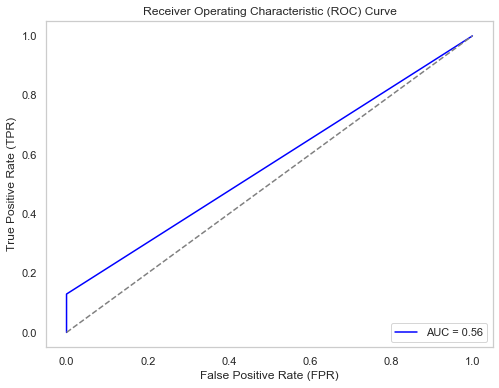

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have a trained model called 'model' and test data X_test and y_test with labels 'yes' and 'no'

# Step 1: Map 'yes' to 1 and 'no' to 0 in the y_test
# y_test_binary = np.where(y_test == 'Yes', 1, 0)
# predictions_binary = np.where(predictions == 'Yes', 1, 0) #this is the addition that I did, before this line it showed "unsupported operand type(s) for -: 'str' and 'str'" because while y_test was converted to int but the values in predictions were still string type

# Step 2: Predict probabilities of the positive class (labeled as 1)
y_prob = classifier.predict_proba(x_test_one)[:, 1]

# Step 3: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

# Step 4: Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_lr)

# Step 5: Plot the AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [39]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


# Model Evaluation

# Cross-validation : model selection

In [14]:
from sklearn.model_selection import cross_val_score

In [73]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [103]:
xcv_fin.head()

,SeniorCitizen,tenure,MonthlyCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,-0.439916,-1.27744,-1.16032,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,-0.439916,0.0663274,-0.259629,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,-0.439916,-1.23672,-0.36266,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,-0.439916,0.514251,-0.746535,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,-0.439916,-1.23672,0.197365,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


# Encoding and Standardization

In [15]:
x_encoded = pd.get_dummies(x, columns=['type'], prefix=['type'])

In [16]:
x_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_encoded)

# Transform the training and test sets using the fitted scaler
X_train_scaled = scaler.transform(x_encoded)

# Convert the scaled arrays back to DataFrames (optional, for visualization purposes)
x_fin = pd.DataFrame(X_train_scaled, columns=x_encoded.columns)

In [18]:
x_fin.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,0.0,0.000002,0.000003,0.0,0.000000,0.000000,0.0,0.0,1.0
1,0.0,0.000002,0.000003,0.0,0.000059,0.000000,0.0,1.0,0.0
2,0.0,0.002479,0.000257,0.0,0.000014,0.000145,0.0,1.0,0.0
3,0.0,0.002329,0.000012,0.0,0.000063,0.000000,0.0,0.0,1.0
4,0.0,0.003372,0.000182,0.0,0.000018,0.007634,0.0,0.0,1.0


In [19]:
#combining newbalanceDest and oldbalanceDest in train and test dataset and dropping the individual columns
x_fin['balance_comb'] =  x_fin.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)


x_fin = x_fin.drop(['oldbalanceDest','newbalanceDest'],axis=1)
x_fin.head()

,step,amount,oldbalanceOrg,newbalanceOrig,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,balance_comb
0,0.0,0.000002,0.000003,0.0,0.0,0.0,1.0,0.000000
1,0.0,0.000002,0.000003,0.0,0.0,1.0,0.0,0.000059
2,0.0,0.002479,0.000257,0.0,0.0,1.0,0.0,-0.000130
3,0.0,0.002329,0.000012,0.0,0.0,0.0,1.0,0.000063
4,0.0,0.003372,0.000182,0.0,0.0,0.0,1.0,-0.007617


# Cross Validation and Hyper Parameter Tuning using GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf = RandomForestClassifier(random_state=15)

# Define the hyperparameters and their values to explore
param_grid = {
    'n_estimators': [50, 100, 150],        
    'max_depth': [None, 10, 20, 30],       
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4]          
}



In [ ]:
# Initialize GridSearchCV with the classifier, parameter grid and metric
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the data
grid.fit(x_fin, y)

# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)
#the computational time for such a large dataset is pretty high

In [ ]:
grid.cv_results_

In [ ]:
#view results as pandas dataframe
pd.DataFrame(grid.cv_results_)[['mean_test_score','params']]

In [ ]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)


# Conclusion and future analysis

The Random Forest model provides a somehow satisfactory result. However, the Logistic Regression model even though is one of the most common models used with imbalanced dataset, provided a rather unsatisfactory result. Regardless, with such a dataset that is highly imbalanced it I would recommend to break down the large dataset into blocks and perform EDA separately on the minor datasets, preferably a system that can handle parallel computation. This step shoud be done after properly applying artificial sampling techniques with consent from the stakeholder, or else the imbalance in the smaller blocks of data would also increase that would lead to data inaccuracies. 

# What are the key factors that predict fraudulent customer?

Predicting fraudulent customers involves identifying patterns and characteristics that differentiate them from non-fraudulent customers. Some common key factors that often predict fraudulent customers include:

Unusual Transaction Activity: Fraudulent customers often engage in unusual transaction patterns, such as large or frequent transactions, transactions in atypical locations, or transactions inconsistent with their historical behavior.

High-Risk Geographical Locations: Transactions from high-risk geographical areas or countries known for a high incidence of fraud may raise suspicion.

Abnormal Usage of Payment Methods: Customers who frequently change payment methods or use multiple payment sources for similar transactions may be flagged as suspicious. In our dataset we saw fraudelent transactions were made with only two modes of payment.

Unusual Account Behavior: Rapid changes in account details, such as contact information or shipping addresses, could indicate fraudulent activity.

Previous Fraud History: Customers with a history of fraud or suspicious behavior are more likely to engage in fraudulent activity again.

Identity Verification Failures: Customers who repeatedly fail identity verification checks may be attempting to use stolen credentials.

Inconsistent Personal Information: Discrepancies in provided personal information, such as mismatched names or addresses, could raise red flags.

# What kind of prevention should be adopted while company update its infrastructure?

The following can be adopted in hindsight to prevent/mitigate fraudelent transactions:
    
Regular Check on Behavioral Patterns: Fraudulent customers often exhibit distinct behavior from regular customers. Identifying these patterns allows for targeted fraud prevention.

Risk Assessment: By considering factors associated with higher risk, businesses can prioritize verification and monitoring efforts effectively. Usually risk assessments are just for compliance purposes in many business. Investing in risk analysis can lead to a significant upgradation in integrity of the company

Historical Data: Past fraudulent incidents provide valuable insights for understanding potential future fraudulent activity.

Real-time Monitoring: Analyzing these factors in real-time allows for immediate action and prevention of fraudulent transactions.

# Assuming these actions have been implemented, how would you determine if they work?

The above actions should be incorporated with regular additional records on the dataset and applying proper methods to sample the dataset so that would be capable of handling imbalance and prevent overfitting or underfitting. Given these methods are properly applied,we can determine whether they work or not by various metrics like Accuracy,Precision,Recall,F1-score, confusion matrix. The key is to focus on those metrics which align with our problem statement.
For ex: if false negatives (undetected fraud) are more critical, you would prioritize recall. If you want to minimize false positives (legitimate transactions flagged as fraudulent), you would prioritize precision. 
In addition to this we should always prepare for unprecedented ways of fraudelent transaction, which can be achieved by regular updation and monitoring. 